# Using Tf to form a model

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [4]:
test_dataset = pd.read_csv("data/test.csv")
train_dataset = pd.read_csv("data/train.csv")
columns = ["img_paths", "labels"]

In [42]:
test_dataset = test_dataset.sample(frac=1)
train_dataset = train_dataset.sample(frac=1)

In [51]:
# test_dataset.drop(columns=["Unnamed: 0"], inplace=True)
# train_dataset.drop(columns=["Unnamed: 0"], inplace=True)
test_dataset.reset_index(inplace=True, drop=True)
train_dataset.reset_index(inplace=True, drop=True)

In [62]:
img = cv2.imread("data/data/test/0/103277.png", cv2.IMREAD_GRAYSCALE)
img.shape

(32, 32)

In [63]:
import time
def load_dataset(df):   
    ##############Getting the image Paths#################
#     df = pd.read_csv(path)
    img_paths = df.img_paths
    labels = df.labels
    ######################################################
    ##############Reading the images Grayscale############
    imgs = []
    for img in img_paths:
#         start = time.time()
        temp = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        imgs.append(temp)
#         end = time.time()
#         print(end-start)
        
    ######################################################
    #######Converting to numpy array for faster calculations#####
    labels = np.asarray(labels).astype('uint8')
    imgs = np.asarray(imgs)
    return labels, imgs

In [64]:
y_train, x_train = load_dataset(train_dataset)
y_test, x_test = load_dataset(test_dataset)

In [77]:
import pickle
filenames = ["dump/x_train.txt","dump/x_test.txt", "dump/y_train.txt","dump/y_test.txt"]
listings = [x_train, x_test, y_train, y_test]
for listing, filename in zip(listings, filenames):
    f = open(filename, 'wb')
    pickle.dump(listing, f)

# Load Data (Alternative starting point)

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 

In [6]:
import pickle
filenames = ["dump/x_train.txt","dump/x_test.txt", "dump/y_train.txt","dump/y_test.txt"]
f = open(filenames[0], 'rb')
x_train  = pickle.load(f)
f = open(filenames[1], 'rb')
x_test = pickle.load(f)
f = open(filenames[2], 'rb')
y_train = pickle.load(f)
f = open(filenames[3], 'rb')
y_test = pickle.load(f)

In [7]:
def oneHotEncode(data):
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False) # disable sparse return type
    
    # reshape the array
    data = data.reshape(len(data), 1)
    data = onehot_encoder.fit_transform(data) 
    return data

In [8]:
y_test = oneHotEncode(y_test)
y_train = oneHotEncode(y_train)

In [9]:
x_train = x_train.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)

In [15]:
x_test = x_test/255
x_train = x_train/255

In [19]:
np.min(x_test)

0.0

# Model

In [23]:
def create_model(img_height, img_width, img_ch, num_classes):
    model = Sequential([
#         layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, img_ch)),
        layers.Conv2D(16, 3,input_shape=(img_height, img_width, img_ch), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)        
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


In [33]:
def create_model2(img_height, img_width, img_ch, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(img_height, img_width, img_ch)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

In [24]:
model = create_model(32,32,1,46)

In [34]:
model = create_model2(32,32,1,46)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [37]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Conv2d.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=5)

Epoch 1/5
782/782 [==============================] - 71s 91ms/step - loss: 0.0073 - accuracy: 0.7587 - val_loss: 0.0038 - val_accuracy: 0.8842
Epoch 2/5
782/782 [==============================] - 71s 90ms/step - loss: 0.0062 - accuracy: 0.7968 - val_loss: 0.0032 - val_accuracy: 0.9005
Epoch 3/5
782/782 [==============================] - 74s 95ms/step - loss: 0.0056 - accuracy: 0.8163 - val_loss: 0.0028 - val_accuracy: 0.9137
Epoch 4/5
782/782 [==============================] - 75s 96ms/step - loss: 0.0051 - accuracy: 0.8347 - val_loss: 0.0025 - val_accuracy: 0.9222
Epoch 5/5
782/782 [==============================] - 77s 99ms/step - loss: 0.0047 - accuracy: 0.8473 - val_loss: 0.0023 - val_accuracy: 0.9288


In [5]:
plt.imshow(x_train[0])
# plt.imshow(y_train[0])
np.argmax(y_train[0])

NameError: name 'x_train' is not defined

# Visualizing the model

ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

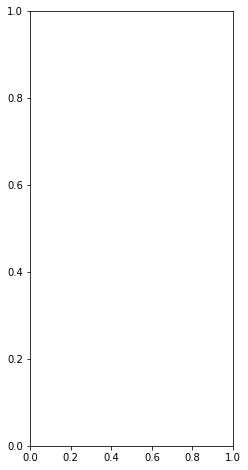

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Saving Model

In [29]:
model.save("models/Conv2d.h5")
del model

# Loading the model

In [30]:
model = tf.keras.models.load_model("models/Conv2d.h5")

In [42]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "model_js")

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.002279395703226328
Test accuracy: 0.9288405776023865
